Python version of a R code originaly developped by Coryn Bailer-Jones : 3D posterior for a single stars

see also 
* Gaia Archive : https://archives.esac.esa.int/gaia
* Coryn Bailer-Jones "Practical Bayesian Inference", http://tinyurl.com/statsprimer

# Packages

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib as mp
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
import emcee

# Various mathematical and astronomical constants

In [5]:
# mathematical constants
conv = np.pi/180 # degrees -> radians
km = 1e3      # km in SI (m)

# physical constants
#G <- 6.67428e-11 # gravitational constant

# solar system constants
sgp = 1.32712440018e20   # standard gravitational constant in SI (G*Msun)
yr  = 365.25*24*3600     # length of Julian year in SI (s). Tropical year is 365.242190 days
au  = 1.495978701e11     # AU in SI (m) (Hipparcos catalogue documentation p. 25, Table 1.2.2)
pc  = (3600*180/np.pi)*au   # parsec in SI (m) [3.085678e+16]
kf  = au/(yr*km)         # 1 AU/yr in km/s. Units: km s^-1 yr [4.740471]
                          # converts proper motion of 1as/yr at 1pc to velocity in km/s 
                          # year unit here must be same as in PMs

# Galactic coordinate system constants (l is Galactic longitude)
# theta0, raNGP, decNGP uniquely define the equatorial to Galactic coordinate transformation.
# With the Hipparcos values for these, the matrix trans in eq.to.gal() is equal the transpose 
# of the matrix A_G in the Hipparcos catalogue documentation p. 92, eqn. 1.5.11) to 10 dps.]
theta0 = 90+32.93192  # PA of NGP = l of north celestial pole = 90 + l_omega 
                       # l_omega = l of ascending node of Galactic plane on the equator of ICRS
                       # (Hipparcos catalogue documentation p. 91, eqn. 1.5.10) (theta0=123 in B1950; Johnson & Soderblom 1987) 
raNGP  = 192.85948 # (Hipparcos catalogue documentation p. 91, eqn. 1.5.9)
decNGP = 27.12825  # (Hipparcos catalogue documentation p. 91, eqn. 1.5.9)

# Data model
 * 3D astrometry  (astro3d) = c(parallax, pmra, pmdec) in (mas, mas/yr, mas/yr)
 * 3D phase space (phase3d) = c(r, v, phi) in (pc, km/s, radians)
 * r is distance, v is tangential speed, phi is position angle from North to East
 * astro3dCov is 3x3 covariance matrix of astro3d in same units (e.g. made by cov.astro3d)
 * rlen is length scale of distance prior; vtmax is maximum tangential speed (parameter of speed prior)
 * astromdat: matrix with named columns, from which we require:
     * astro3d
     * standard deviations in astro3d as well as their corresponding correlations. 
   (name of which are given in cov.astro3d() below).

## Read preloaded GDR1 data and set parameter names

In [6]:
astromdat = pd.read_csv("data/gdr1set02.csv")

In [7]:
astromdat[1:5]

,hip,tycho2_id,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,scan_direction_mean_k4,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_variable_flag,l,b,ecl_lon,ecl_lat
1,NaN,2390-806-1,1635378410781933568,180191882570106752,1680357,2015.0,79.354017,0.388151,30.703964,0.304991,...,40.196415,86,1.603336e+06,3678.334112,10.012209,NOT_AVAILABLE,175.168322,-4.150353,80.778476,7.604841
2,NaN,2390-1216-1,1635378410781933568,180191264094816256,1967931,2015.0,79.322877,0.564212,30.667288,0.443664,...,40.325287,94,3.354454e+05,297.334579,11.710715,NOT_AVAILABLE,175.182973,-4.193350,80.748787,7.570255
3,NaN,2390-984-1,1635378410781933568,180161164965929984,1147158,2015.0,78.953340,1.002317,30.459020,0.782360,...,39.876610,51,2.539588e+05,186.236365,12.012862,NOT_AVAILABLE,175.169727,-4.573416,80.412899,7.386639
4,NaN,2390-271-1,1635378410781933568,180286715449520512,884496,2015.0,79.422292,0.287440,30.828602,0.251413,...,40.619034,85,2.589245e+06,1500.895351,9.491837,NOT_AVAILABLE,175.099849,-4.030721,80.846805,7.724802


In [8]:
phase3dnames = ["distance", "speed", "angle"]
astro3dnames = ["parallax", "pmra", "pmdec"]
astro3derrornames = ["parallax_error", "pmra_error", "pmdec_error",
                     "parallax_pmra_corr","parallax_pmdec_corr","pmra_pmdec_corr"]

a source

In [9]:
s = astromdat[astro3dnames].values[0]

In [10]:
s

array([ 0.35443596,  2.64738601, -4.39060089])

and its error

In [11]:
s_error = astromdat[astro3derrornames].values[0]

In [12]:
s_error

array([ 0.98082899,  0.63170792,  0.83257706,  0.16941312,  0.2959965 ,
        0.01683142])

# some functions
## convert parallax and proper motion to distance and velocity

In [13]:
def phase3d(parallax, pmra, pmdec) :
    dist = 1e3/parallax
    speed = kf*np.sqrt(pmra**2 + pmdec**2)/parallax
    phi = np.arctan2(pmra,pmdec)
    return np.array([dist, speed, phi])

In [14]:
phase3d(*s)

array([  2.82138417e+03,   6.85718961e+01,   2.59899463e+00])

## to create and convert the corresponding covariance matrices

In [15]:
 
def jac3d(parallax, pmra, pmdec):
    """Evaluate Jacobian matrix |d_phase3d / d_astro3d| at a given astro3d"""
    musq = pmra**2 + pmdec**2
    mu = np.sqrt(musq)
    J = np.matrix([[-1e3/parallax, 0, 0],
                   [-kf*mu/parallax**2, kf*pmra/(mu*parallax), kf*pmdec/(mu*parallax)],
                    [0, pmdec/musq, -pmra/musq]])
    return J

def astro3dcov(parallax_error,pmra_error,pmdec_error,
               parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr) :
    """Make covariance matrix for astro3d from astromdat"""
    # V is upper diagonal of covariance matrix  
    V = np.matrix([[0,parallax_error*pmra_error*parallax_pmra_corr, parallax_error*pmdec_error*parallax_pmdec_corr],
                 [0, 0,pmra_error*pmdec_error*pmra_pmdec_corr],
                 [0, 0, 0]])
    S = np.diag([parallax_error**2,pmra_error**2,pmdec_error**2]) # variances!
    return S + V + V.transpose()

In [16]:
jac3d(*s)

matrix([[ -2.82138417e+03,   0.00000000e+00,   0.00000000e+00],
        [ -1.93467662e+02,   6.90618881e+00,  -1.14536825e+01],
        [  0.00000000e+00,  -1.67031731e-01,  -1.00714567e-01]])

In [17]:
astro3dcov(*s_error)

matrix([[ 0.96202552,  0.10496794,  0.2417154 ],
        [ 0.10496794,  0.3990549 ,  0.00885241],
        [ 0.2417154 ,  0.00885241,  0.69318457]])

from covariance to correlation

In [18]:
cor =astro3dcov(*s_error)

In [19]:
np.corrcoef(cor)

array([[ 1.        , -0.42049834, -0.0333318 ],
       [-0.42049834,  1.        , -0.89277319],
       [-0.0333318 , -0.89277319,  1.        ]])

## beta distribution
 density of a beta function shifted and scaled to lie in range

In [20]:
from scipy.stats import beta, uniform

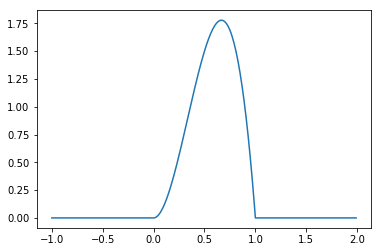

In [21]:
x=np.arange(-1,2,0.01)
plt.plot(x,beta.pdf(x, 3, 2))

## integration
integral of f over its first argument from lower to upper.

In [22]:
from scipy.integrate import quad

def f(x):
    return 0.01*x**-3

integral, error = quad(f, 1000, np.inf, epsrel = 1e-6,epsabs = 0)

In [23]:
print(integral,error)

5e-09 4.036193611405873e-18


## probablitly density function

In [24]:
# Given a 1D unnormalized posteior PDF "dense" computed on a grid "x", 
# return 3-element named list of normalization constant, mean, SD (essentially moments 0,1,2).
# The grid must have sufficient density and span to cover essentially all of the density,
# but it need not be uniform (CHECK)
# See PBI section 5.1.1 for details.
def pdfmom(dense, x) :
    if(length(x)!=length(x)) : raise ValueError("dense and x must have same size")
    if(length(x)<=1) : raise ValueError("dense and x must have at least two elements")
    deltax = np.mean(diff(x))
    xNorm = deltax*np.sum(dense)
    dense = dense/xNorm # dense is now normalized
    xMean = deltax*np.sum(x*dense)
    xSD = sqrt( deltax * sum((x-xMean)^2 * dense) )
    return xNorm, xMean, xSD

## Prior

model parameters

In [25]:
rlen  = 500 # pc;   length scale of distance prior
vtmax = 750 # km/s; maximum transverse speed (speed prior)

In [26]:
def distPrior(d):
    return (1/(2*rlen**3))*(d**2)*np.exp(-d/rlen) if (d>0) else 0

In [27]:
x = np.arange(-rlen,20*rlen,0.01*rlen)
y = [distPrior(v) for v in x]

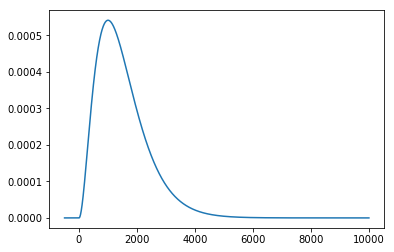

In [28]:
plt.plot(x,y)

In [29]:
def speedPrior(s):
    return beta.pdf(s/vtmax,2,3)

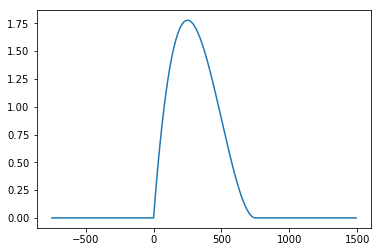

In [30]:
x = np.arange(-vtmax,2*vtmax,0.01*vtmax)
plt.plot(x,speedPrior(x))

In [31]:
def anglePrior(a):
    return uniform.pdf(a,0,2*np.pi)

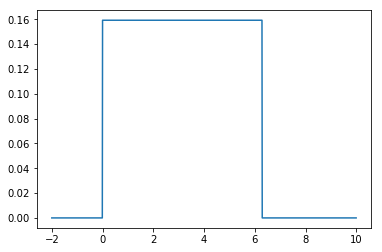

In [32]:
x = np.arange(-2,10,0.01)
plt.plot(x,anglePrior(x))

In [33]:
np.log10(0)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


-inf

In [34]:
def log_prior(model):
    """Return log10 (unnormalized) prior: P(3D phase space | rlen, vtmax)"""
    phase3d = model
    return np.log10(distPrior(phase3d[0])) + np.log10(speedPrior(phase3d[1])) + np.log10(anglePrior(phase3d[2]))

## Likelyhood

In [35]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
var.pdf([1,0])

0.096532352630053928

In [36]:
def log_likelihood(model,data) :
    """Return log10 (normalized) likelihood: P(3D astrometry | 3D phase space, Covariance)"""
    astro3d, astro3dCov = data
    phase3d = model
    a = phase3d[1]/(kf*phase3d[0])
    pred = 1e3*np.array([1/phase3d[0], a*np.sin(phase3d[2]), a*np.cos(phase3d[2])])
    f = multivariate_normal(mean=pred, cov=astro3dCov) # can be replace by a matrix product...
    return f.logpdf(astro3d)/np.log(10)

## Posterior

In [37]:
def log_posterior(model,data) :
    logprior = log_prior(model)
    res = logprior + log_likelihood(model,data) if np.isfinite(logprior) else -np.inf
    return np.array(res)

In [38]:
def vlog_posterior(models,datas) :
    res = []
    for i,(model,data) in enumerate(zip(models,datas)) :
        res.append(log_posterior(model,data))
    return np.array(res)

# Inference

## source values

In [39]:
print("astro3d",s)

astro3d [ 0.35443596  2.64738601 -4.39060089]


In [40]:
phase = phase3d(*s)
print("phase3d",phase)

phase3d [  2.82138417e+03   6.85718961e+01   2.59899463e+00]


In [41]:
cov = astro3dcov(*s_error)
print("astro3dcov",cov)

astro3dcov [[ 0.96202552  0.10496794  0.2417154 ]
 [ 0.10496794  0.3990549   0.00885241]
 [ 0.2417154   0.00885241  0.69318457]]


In [42]:
jac = jac3d(*s)
phaseCov = jac * astro3dcov(*s_error) * jac.transpose()
print("phase3dcov",phaseCov)

phase3dcov [[  7.65792380e+06   5.30884144e+05   1.18151775e+02]
 [  5.30884144e+05   3.69076727e+04   8.45196375e+00]
 [  1.18151775e+02   8.45196375e+00   1.84625765e-02]]


In [43]:
print("phase3d errors",np.sqrt(np.diag(phaseCov)))

phase3d errors [  2.76729539e+03   1.92113697e+02   1.35877064e-01]


In [44]:
model0 = phase
data = s, cov

In [45]:
print("Initial logposterior : ",log_posterior(model0,data))

Initial logposterior :  -5.672132465463851


## MCMC with emcee

In [46]:
ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nsteps = 1000  # number of MCMC steps

### initialise each walkers value : set theta near the maximum likelihood 

In [47]:
np.random.seed(0)
def init(Nwalker, phase3d, vtmax):
    """ to initialise each walkers value : sets theta near the maximum likelihood """
    distwidth = 10
    d=phase3d[0]
    if(phase3d[0]<distwidth/2) : 
        dist = np.random.uniform(0,distwidth,Nwalker)
    else :
        dist = np.random.uniform(d-distwidth/2, d+distwidth/2,Nwalker)
  
    speedwidth = 10
    if(phase3d[1]<speedwidth/2) :
        speed = np.random.uniform(0, distwidth, Nwalker)
    if(phase3d[1]>vtmax-speedwidth/2) :
        speed = np.random.uniform(vtmax-speedwidth,vtmax,Nwalker)
    if( (phase3d[1]>=speedwidth/2) and (phase3d[1]<=vtmax-speedwidth/2)) :
        speed = np.random.uniform(phase3d[1]-speedwidth/2, phase3d[1]+speedwidth/2,Nwalker)
      
    anglewidth = np.pi/2
    angle = np.random.uniform(phase3d[2]-anglewidth/2, phase3d[2]+anglewidth/2,Nwalker)
    return np.transpose(np.array([dist, speed, angle] ))

In [48]:
starting_guesses = init(nwalkers,phase,vtmax)

### sampling the parameter space

In [49]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
%time x = sampler.run_mcmc(starting_guesses, nsteps)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


CPU times: user 24.6 s, sys: 161 ms, total: 24.8 s
Wall time: 24.8 s


### output of the emcee algorithm :
the result of the last sample, not very usefull

In [50]:
help(sampler.run_mcmc)

Help on method run_mcmc in module emcee.sampler:

run_mcmc(pos0, N, rstate0=None, lnprob0=None, **kwargs) method of emcee.ensemble.EnsembleSampler instance
    Iterate :func:`sample` for ``N`` iterations and return the result.
    
    :param pos0:
        The initial position vector.  Can also be None to resume from
        where :func:``run_mcmc`` left off the last time it executed.
    
    :param N:
        The number of steps to run.
    
    :param lnprob0: (optional)
        The log posterior probability at position ``p0``. If ``lnprob``
        is not provided, the initial value is calculated.
    
    :param rstate0: (optional)
        The state of the random number generator. See the
        :func:`random_state` property for details.
    
    :param kwargs: (optional)
        Other parameters that are directly passed to :func:`sample`.
    
    This returns the results of the final sample in whatever form
    :func:`sample` yields.  Usually, that's:
    ``pos``, ``lnprob``, `

In [51]:
pos, lnprop, rstate = x

In [52]:
np.shape(pos)

(50, 3)

In [53]:
np.shape(lnprop)

(50,)

### result is in the sampler chains

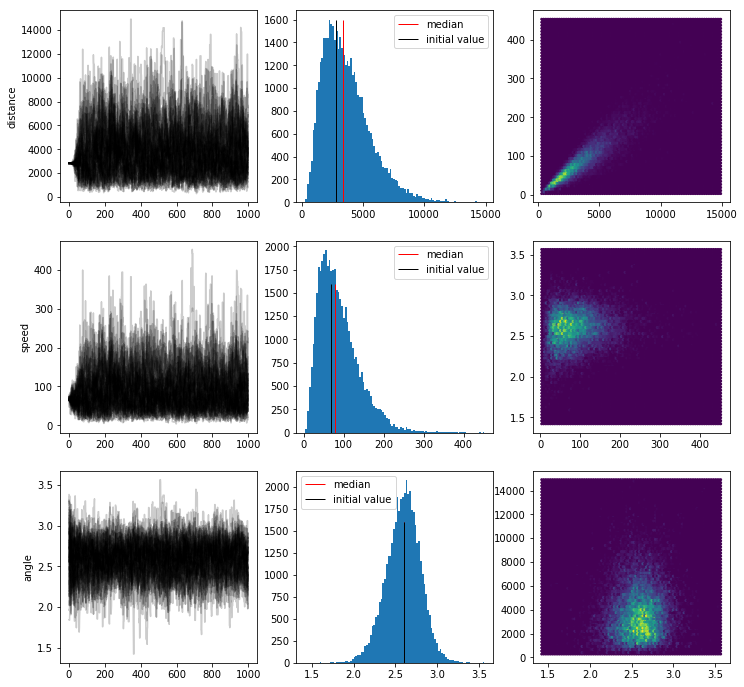

In [54]:
def plot_chains(sampler):
    fig, ax = plt.subplots(3,3, figsize=(12, 12))
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
    for i in range(3):
        ax[i,0].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i,0].set_ylabel(phase3dnames[i])
        ax[i,1].hist(samples[:,i],bins=100);
        ax[i,1].vlines(np.median(samples[:,i]),0,1600,lw=1,color='r',label="median")
        ax[i,1].vlines(phase[i],0,1600,lw=1,label="initial value")
        ax[i,1].legend()
        ax[i,2].hexbin(samples[:,i],samples[:,(i+1)%3])#,s=1,alpha=0.1);
plot_chains(sampler)